# Team Assignment 2  
# HE 381

## Team Members  
1. Abhijeet Bhatta (25169)
2. Ankush Kumar (24033)
3. Chanyanka Kakati (27228) 
4. Suman Dafadar (24139)


## Question 3

In [474]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy as np
from qiskit.circuit import Gate

In [475]:
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt

# Test Circuit

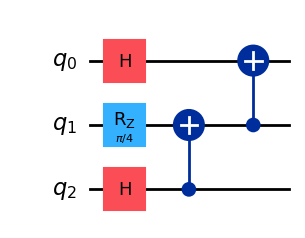

In [476]:
u_circ = QuantumCircuit(3)
u_circ.h(0)
u_circ.rz(np.pi/4, 1)
u_circ.h(2)
u_circ.cx(2, 1)
u_circ.cx(1, 0)
u_circ.draw("mpl")
# Convert to a Gate




In [477]:
U_gate = u_circ.to_gate()
U_gate.name = "U"

## Sanity Check for Correctness of Circuit

Unitary of the circuit in Question 3 == U

In [478]:
I = np.array([
    [1, 0],
    [0, 1]
    ])
H = np.array([
    [1/np.sqrt(2), 1/np.sqrt(2)], 
    [1/np.sqrt(2), -1/np.sqrt(2)]
])
Rz = np.array([
    [np.exp(-(1j * np.pi /8)), 0],
    [0, np.exp(1j * np.pi /8)]
    ])

CNOT = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
    ])
state = np.kron(H,Rz)
state = np.kron(state,H)
U = ( (np.kron(I, CNOT)@ (np.kron(CNOT, I)) @ state))

Unitary of circuit made in Qiskit == CircU

In [479]:
CircU = Operator(u_circ).data
CircU == U

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

# Eigenvalue and Eigenstate calculation

In [480]:
val, vecc = np.linalg.eig(U) 
for i in range(len(val)):    
    r = np.abs(val[i])

    # Phase angle (phi, in radians)
    phi = np.angle(val[i]) / 2 / np.pi
    print(i, r, phi)

0 1.0 -0.26354392014819966
1 0.9999999999999998 -0.48131363198611027
2 1.0000000000000009 0.4375
3 0.9999999999999997 -0.12728878388272968
4 0.9999999999999998 -0.06250000000000006
5 0.9999999999999992 0.2750228722248246
6 0.9999999999999996 0.062499999999999944
7 1.0 0.15962346379221498


Eigenvector for eigenvalue exp(2*pi*i * (1/16) )

In [481]:
vecc[:,6]
eigenvec = vecc[:,6]
eigenvec = eigenvec / np.linalg.norm(eigenvec)
eigenvec

array([-2.77555756e-17-4.61939766e-01j, -3.67761377e-16-1.91341716e-01j,
        4.61939766e-01+0.00000000e+00j, -1.91341716e-01-5.55111512e-17j,
        4.61939766e-01-3.19189120e-16j,  1.91341716e-01-1.38777878e-16j,
       -1.91341716e-01+1.24900090e-16j, -4.61939766e-01+3.74700271e-16j])

Confirmation that Eigenvec is correct

In [482]:
u_vec = U @ eigenvec

# --- find candidate eigenvalue lambda by projecting ---
# lambda = <v|U|v> / <v|v>  (since vec is normalized, denom=1)
lam = np.vdot(eigenvec, u_vec)   # complex scalar

# --- check if U*vec == lambda * vec (within tolerance) ---
residual = u_vec - lam * eigenvec
residual_norm = np.linalg.norm(residual)

print("candidate eigenvalue λ =", lam)
print("abs(|λ|) =", abs(lam))
print("residual norm ||U v - λ v|| =", residual_norm)

candidate eigenvalue λ = (0.923879532511287+0.38268343236508984j)
abs(|λ|) = 1.0000000000000002
residual norm ||U v - λ v|| = 9.46440709782976e-16


# Quantum Phase Estimation Circuit

In [483]:
def QPE(n_ancilla, vec)  :
    n_target = 3
    # Create circuit: ancilla + 1 target
    qc = QuantumCircuit(n_ancilla + n_target, n_ancilla)

    # Initialize target qubit to |1>
    # qc.x(n_ancilla)  # target is last qubit
    qc.initialize(vec, range(n_ancilla, n_ancilla + n_target))
    # Step 1: Hadamard on ancilla qubits
    qc.h(range(n_ancilla))

    # Step 2: Controlled-Rz operations

    def U2_control(n):
        qc_u2 = QuantumCircuit(3)
        qc_u2.unitary(U_gate.power(2**n), [0, 1, 2])
        label_str = 'U^{2^' + f'{n}' + '}'
        u2_control = qc_u2.to_gate(label=f'${label_str}$').control(1)
        return u2_control # Controlled-U^(2^n) gate


    for i in range(n_ancilla):
        qc.append(U2_control(i), [i] + list(range(n_ancilla, n_ancilla + n_target)))


    # Step 3: Built-in inverse QFT on ancilla
    iqft = QFT(num_qubits=n_ancilla, inverse=True, do_swaps=True).to_gate()
    iqft.name = "IQFT"
    qc.append(iqft, range(n_ancilla))

    # Step 4: Measurement
    qc.measure(range(n_ancilla), range(n_ancilla))
    # Draw circuit
    qc.draw('mpl', style={'displaycolor': {'IQFT': ('#000000', '#FFFFFF')}})
    return qc




# Run for exactly representable Phase ( 2* pi * i * (7/16))

In [484]:
vecc[:,2]
eigenvec1 = vecc[:,2]
eigenvec1 = eigenvec1 / np.linalg.norm(eigenvec1)
eigenvec1

array([-0.27811132-0.13905566j,  0.69527831+0.j        ,
       -0.11519748-0.05759874j,  0.05759874-0.11519748j,
       -0.13905566+0.27811132j,  0.27811132+0.13905566j,
        0.27811132+0.13905566j, -0.13905566+0.27811132j])

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=2>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


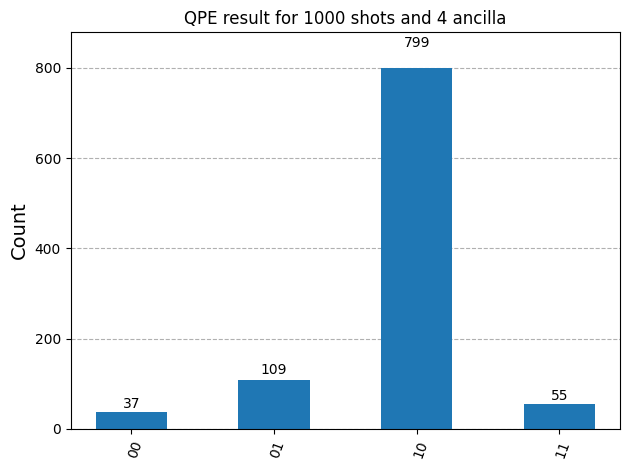

In [485]:
qc = QPE(2,eigenvec1)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {n_ancilla} ancilla")

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


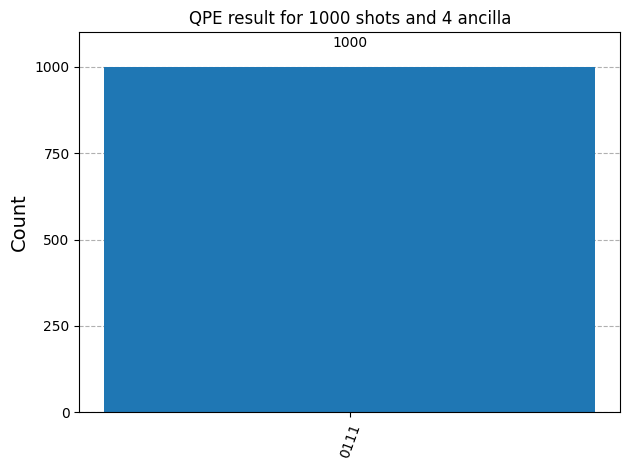

In [486]:
qc = QPE(4,eigenvec1)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {n_ancilla} ancilla")

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=8>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


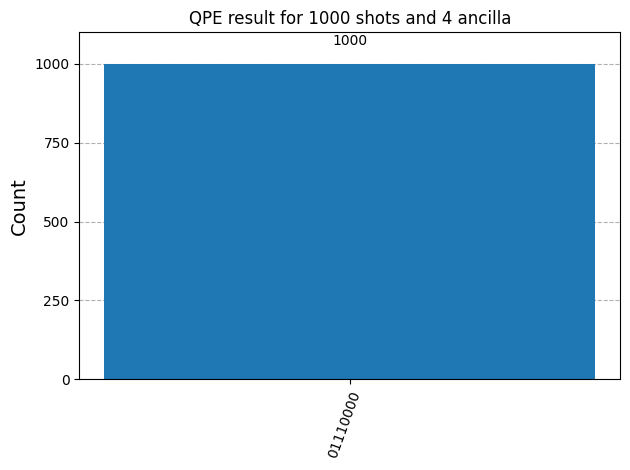

In [487]:
qc = QPE(8,eigenvec1)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {n_ancilla} ancilla")

Answer = bin(0.1110000) = 0.4375 = 7/16

# Run for arbitrary phase ( 2 * pi * i * 0.2750228722)

In [488]:
vecc[:,5]
eigenvec2 = vecc[:,5]
eigenvec2 = eigenvec2 / np.linalg.norm(eigenvec2)
eigenvec2


array([-0.08824381-0.16349267j, -0.14609781+0.28231037j,
       -0.02730142+0.46704356j,  0.31751776-0.09762434j,
        0.10941587-0.09839546j,  0.49593819+0.j        ,
       -0.264214  -0.0986486j ,  0.31201551+0.30118751j])

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=2>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


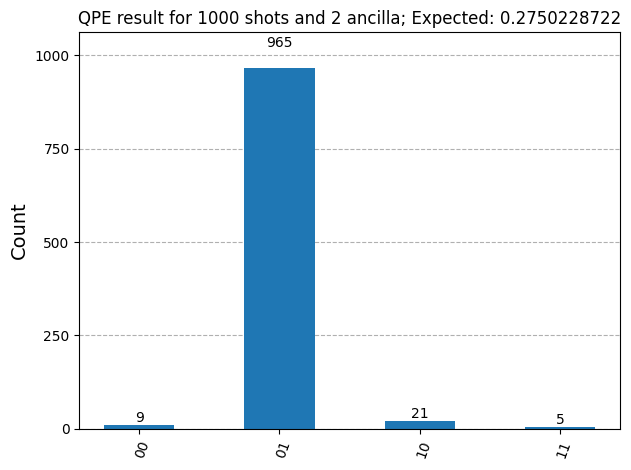

In [489]:
qc = QPE(2,eigenvec2)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {2} ancilla; Expected: 0.2750228722")

Answer = bin(0.01) = 0.25

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


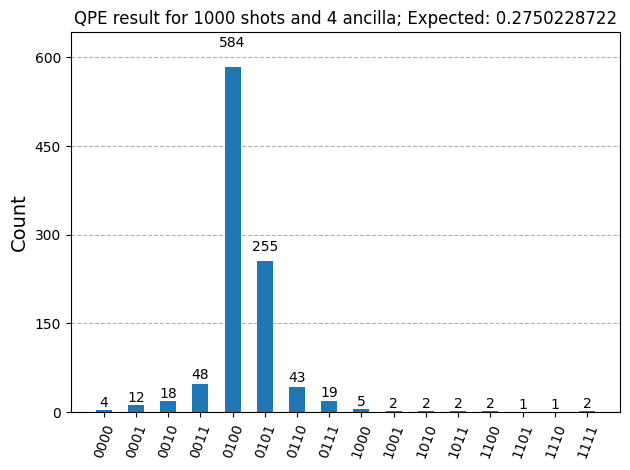

In [490]:
qc = QPE(4,eigenvec2)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {4} ancilla; Expected: 0.2750228722")

Answer = bin(0.0100) = 0.25

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=6>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


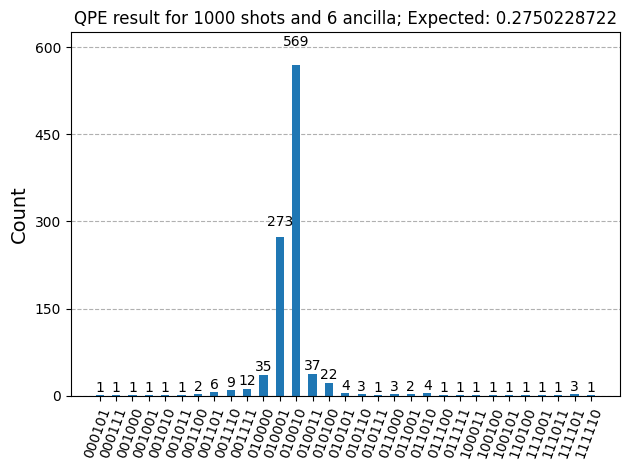

In [491]:
qc = QPE(6,eigenvec2)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {6} ancilla; Expected: 0.2750228722")

Answer = bin(0.010010) = 0.28125

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=8>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


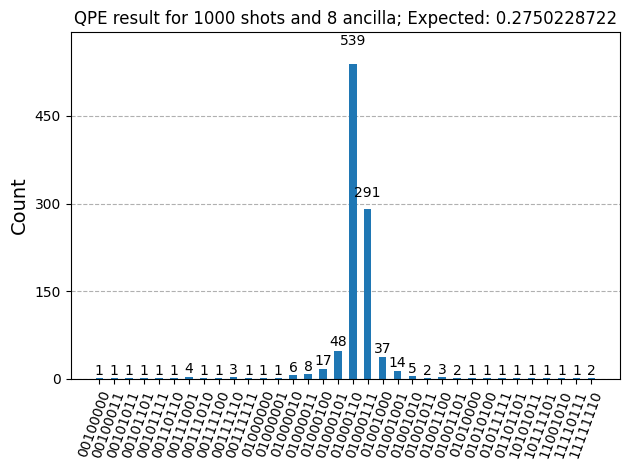

In [492]:
qc = QPE(8,eigenvec2)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {8} ancilla; Expected: 0.2750228722")

Answer = bin(0.01000110) = 0.2734375  

# Superposition of eigenstates

In [493]:
# Raw vector

# 2*pi 1/16

vec = np.array([ 
    1j,
    -1j + 1j*np.sqrt(2),
    -1,
    -1 + np.sqrt(2),
    -1,
    1 - np.sqrt(2),
    -1 + np.sqrt(2),
    1
], dtype=complex)

vec *= 1/np.linalg.norm(vec)

#  2*pi  7 /16
vec2 = np.array([
    1j,
    -1 - 2j,
    -1j + 1j*np.sqrt(2),
    1 - np.sqrt(2),
    1,
    -1j,
    -1j,
    1
], dtype=complex)


vec2 *= 1/np.linalg.norm(vec2)

# #  2*pi 15/16
vec3 = np.array([
    2 - 1j,
    1,
    -1j - 1j*np.sqrt(2),
    1 + np.sqrt(2),
    1,
    -1j,
    -1j,
    1
], dtype=complex)

vec3 *= 1/np.linalg.norm(vec3)
Eigenvec_super = vec + vec2 +vec3



Eigenvec_super = 1/np.linalg.norm(Eigenvec_super) * Eigenvec_super

# def bit_reverse_index(idx, n):
#     b = format(idx, f'0{n}b')
#     return int(b[::-1], 2)

# n = 3
# perm = [bit_reverse_index(i, n) for i in range(2**n)]
# vec_br = vec[perm]   # reorder vector

# Apply prefactor

Results PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'shots': 1000, 'circuit_metadata': {}})], metadata={'version': 2})


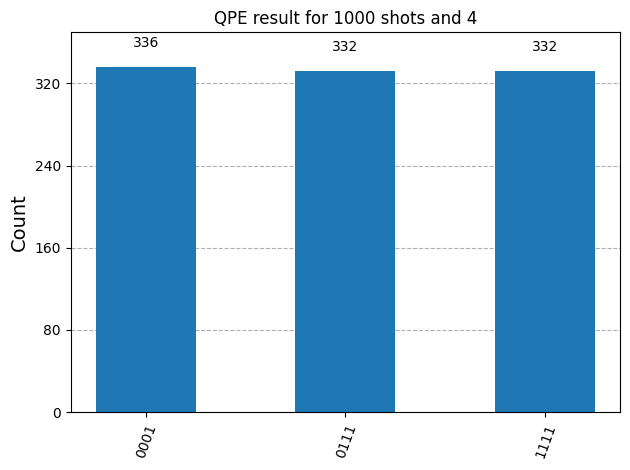

In [494]:
qc = QPE(4,Eigenvec_super)
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(aer_sim)
result = sampler.run([isa_qc], shots = 1000).result()
print("Results",result)

plot_histogram(result[0].data.c.get_counts(),title=f"QPE result for 1000 shots and {n_ancilla}")

0.0001 = 1/16

0.0111 = 7/16

0.1111 = 15/16